In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torchio as tio
import nibabel as nib
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import json

train_or_val = 'train'
DIAMS_PATH = f'/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/{train_or_val}/diams'
IMAGES_PATH = f'/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/{train_or_val}/images'
MASKS_PATH = f'/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/{train_or_val}/masks'
SPRS_PATH = f'/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/{train_or_val}/sprs'


In [2]:
diams_files = os.listdir(DIAMS_PATH)
images_files = os.listdir(IMAGES_PATH)
masks_files = os.listdir(MASKS_PATH)
sprs_files = os.listdir(SPRS_PATH)

def load_npy(dirpath, idx):
    filenames:list[str] = os.listdir(dirpath)
    filenames.sort()
    print(len(filenames))
    filename:str = filenames[idx]
    filepath:str = os.path.join(dirpath, filename)
    return np.load(filepath), filename

3359
3359
Number of positive coordinates: 1426


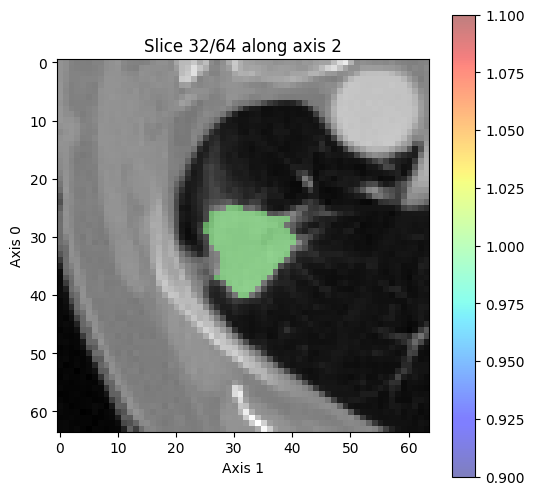

In [3]:
# Display the middle slice along the first axis (e.g., axial view)
# You can change the axis index (0, 1, or 2) to view slices along different planes

patient_idx = 0
axis_to_slice = 2
middle_slice_idx = 32

image, filename = load_npy(IMAGES_PATH, patient_idx)
mask, filename = load_npy(MASKS_PATH, patient_idx)

pos_coords:list[tuple[int, int, int]] = list(zip(*np.where(mask == 1)))
print(f"Number of positive coordinates: {len(pos_coords)}")

image_slice = image.take(indices=middle_slice_idx, axis=axis_to_slice)
mask_slice = mask.take(indices=middle_slice_idx, axis=axis_to_slice)
masked_mask = ma.masked_where(mask_slice == 0, mask_slice)

plt.figure(figsize=(6, 6)) # Optional: Adjust figure size
plt.imshow(image_slice, cmap='gray')
plt.imshow(masked_mask, cmap='jet', alpha=0.5)

plt.title(f'Slice {middle_slice_idx}/{image.shape[axis_to_slice]} along axis {axis_to_slice}')
plt.xlabel(f'Axis {(axis_to_slice + 2) % 3}') # Adjust axis labels based on slice axis
plt.ylabel(f'Axis {(axis_to_slice + 1) % 3}')
plt.colorbar()
plt.show()

3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359
3359


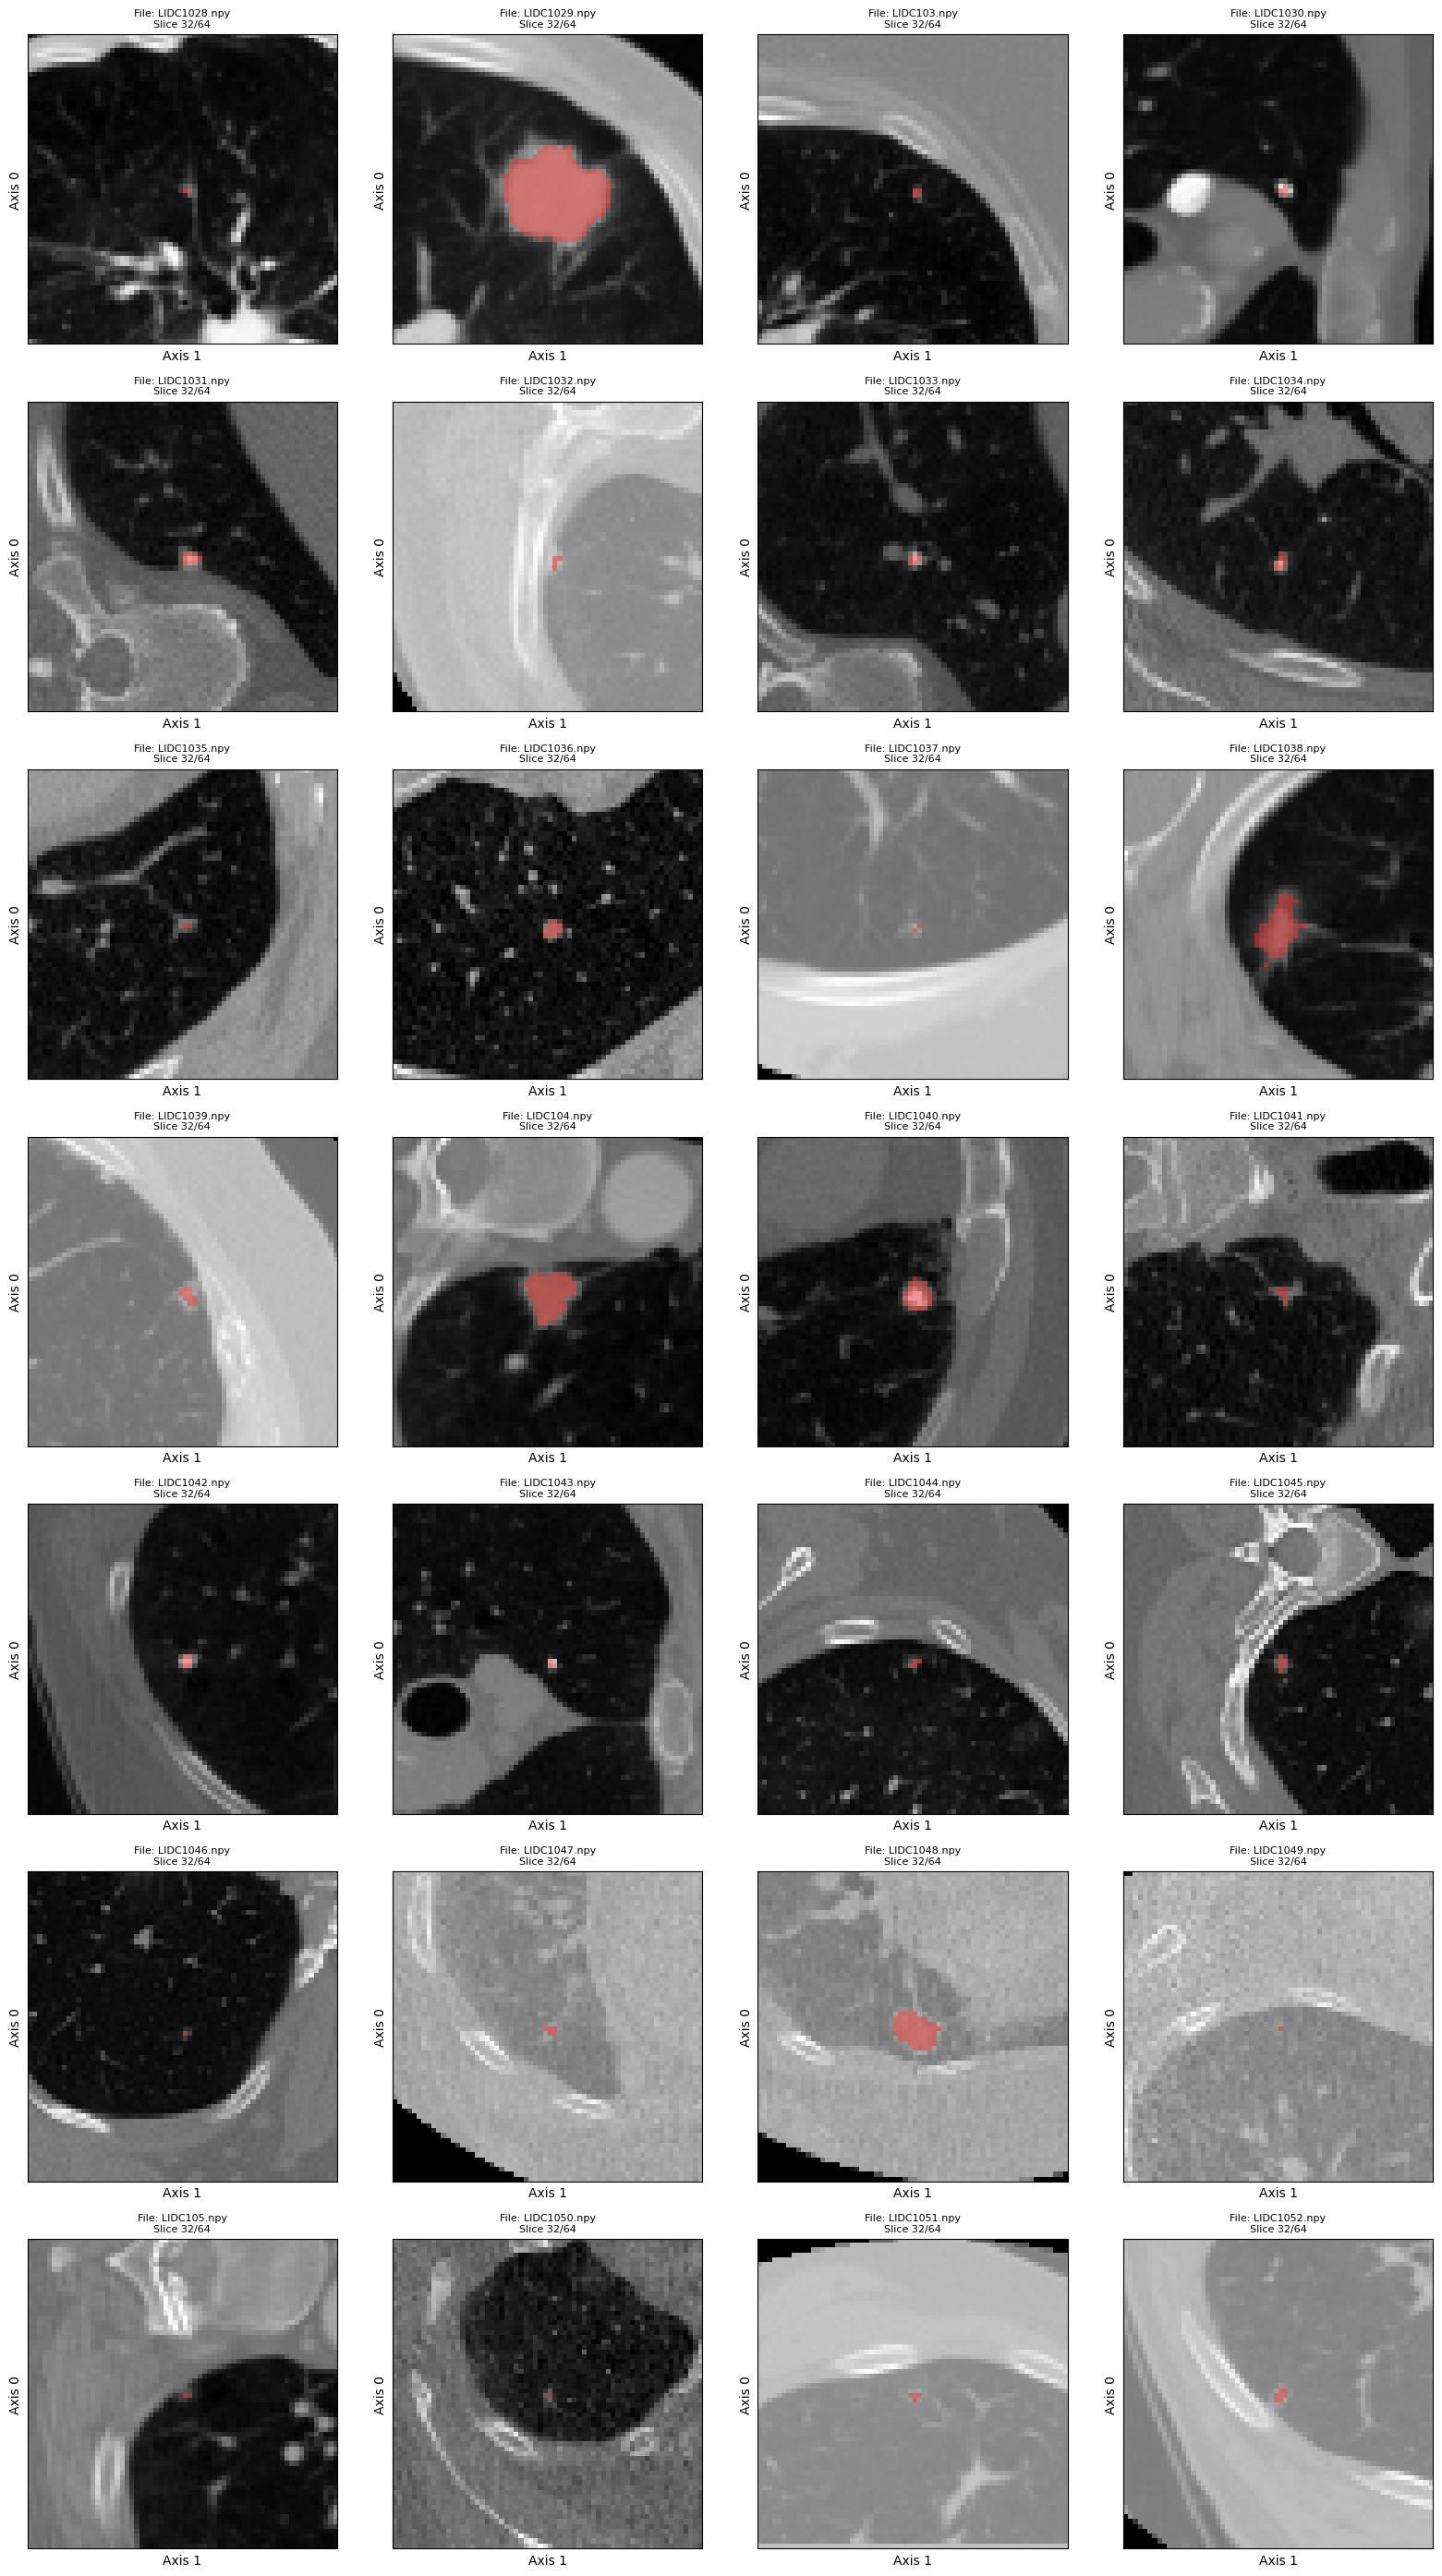

In [4]:
# Display the middle slice along the first axis (e.g., axial view)
# You can change the axis index (0, 1, or 2) to view slices along different planes
patient_indices = [33, 34, 35 ,36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
axis_to_slice = 2
middle_slice_idx = 32

# Calculate number of rows needed for 4 columns
num_patients = len(patient_indices)
num_cols = 4
num_rows = (num_patients + num_cols - 1) // num_cols  # Ceiling division

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Create a custom colormap with only red
# Masked values (0) will be transparent, visible values (1) will be red.

IMAGES_PATH = '/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/LUNA16/data/train/images'
MASKS_PATH = '/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/LUNA16/data/train/masks'

for i, patient_idx in enumerate(patient_indices):
    image, filename = load_npy(IMAGES_PATH, patient_idx)
    mask, _ = load_npy(MASKS_PATH, patient_idx)

    pos_coords = list(zip(*np.where(mask == 1)))
    # Commenting out print statement for cleaner output during plotting multiple images
    # print(f"Patient {patient_idx}: Number of positive coordinates: {len(pos_coords)}")

    image_slice = image.take(indices=middle_slice_idx, axis=axis_to_slice)
    mask_slice = mask.take(indices=middle_slice_idx, axis=axis_to_slice)
    # Create a masked array where mask is 0, leaving only the positive regions (value 1)
    masked_mask = ma.masked_where(mask_slice == 0, mask_slice)

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.imshow(image_slice, cmap='gray')
    ax.imshow(masked_mask, cmap='Reds', alpha=0.5, vmin=0, vmax=1.5)

    ax.set_title(f'File: {filename}\nSlice {middle_slice_idx}/{image.shape[axis_to_slice]}', fontsize=8)
    ax.set_xlabel(f'Axis {(axis_to_slice + 2) % 3}')
    ax.set_ylabel(f'Axis {(axis_to_slice + 1) % 3}')
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused subplots
for j in range(num_patients, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [5]:
#patient_idxs = np.arange(4117) or 1248
print(MASKS_PATH)
patient_idxs = np.arange(len(images_files))
axis_to_slice = 0
middle_slice_idx = 32

# --- Part 1: Iterative loading and counting (necessary due to separate files) ---
print("Loading masks and counting positive voxels...")
pos_counts_list = []
for patient_idx in patient_idxs:
    mask:np.ndarray = load_npy(MASKS_PATH, patient_idx)
    pos_count = np.sum(mask == 1)
    pos_counts_list.append(pos_count)
pos_counts_array = np.array(pos_counts_list)

# --- Part 2: Vectorized duplicate detection ---
print("\nDetecting duplicate groups (vectorized)...")

# Find indices where the count changes
diffs = np.diff(pos_counts_array)
change_indices = np.where(diffs != 0)[0]

# Determine start and end indices of each sequence
starts = np.insert(change_indices + 1, 0, 0)
ends = np.append(change_indices, len(pos_counts_array) - 1)

# Calculate lengths of sequences
lengths = ends - starts + 1

# Filter for sequences longer than 1 (duplicates)
is_duplicate_group = lengths > 1
duplicate_starts = starts[is_duplicate_group]
duplicate_ends = ends[is_duplicate_group]
duplicate_counts = pos_counts_array[duplicate_starts]

# Construct the final list in the desired format
duplicated_patient_idxs_vectorized = []
for count, start, end in zip(duplicate_counts, duplicate_starts, duplicate_ends):
    indices = list(np.arange(start, end + 1))
    duplicated_patient_idxs_vectorized.append((count, indices))

# --- Output Results ---
print(f"\nNumber of duplicated patient sets: {len(duplicated_patient_idxs_vectorized)}")
total_duplicated_counts = sum(len(indices) for _, indices in duplicated_patient_idxs_vectorized)
print(f"Total duplicated counts: {total_duplicated_counts - len(duplicated_patient_idxs_vectorized)}") # Subtract count of sets themselves
print(duplicated_patient_idxs_vectorized)

duplicated_filenames_vectorized = []
images_files.sort()
image_filenames = np.array(images_files)

for count, indices in duplicated_patient_idxs_vectorized:
    duplicated_filenames_vectorized.append((count, list(image_filenames[indices])))
print(duplicated_filenames_vectorized[:10])



/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/val/masks
Loading masks and counting positive voxels...
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320
1320


In [12]:
import sys
sys.path.append('/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/src/data')
from dataset import AllDataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

IMAGE_DIR = f'/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/{train_or_val}/images_2D_0axis/'
MASK_DIR = f'/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/{train_or_val}/masks_2D_0axis/'

dataset = AllDataset(IMAGE_DIR, MASK_DIR, augment=False, normalize=True)
print(len(dataset))

21340


(64, 64) (64, 64)


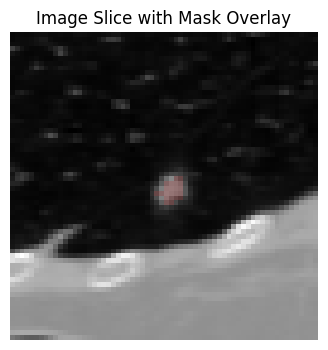

In [19]:
image_2D, mask_2D = dataset[152]

image_2D = image_2D.squeeze(0).numpy()
mask_2D = mask_2D.squeeze(0).numpy()

print(image_2D.shape, mask_2D.shape)
# --- Create Overlay Plot ---

# Create a masked version of the mask where zeros are masked (transparent)
# This assumes mask values > 0 should be overlaid. Adjust condition if needed (e.g., mask_2D == 1)
masked_mask = np.ma.masked_where(mask_2D == 0, mask_2D)

plt.figure(figsize=(4, 4)) # Adjust size as needed

# 1. Plot the base grayscale image
plt.imshow(image_2D, cmap='gray')

# 2. Plot the mask overlay on top
# Define colors: 0 -> transparent, 1 -> semi-transparent red (RGBA format)
colors = [(0, 0, 0, 0), (1, 0, 0, 0.5)] # (R, G, B, Alpha)
# Define the values in your mask that correspond to these colors
nodes = [0.0, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_mask", list(zip(nodes, colors)))
plt.imshow(mask_2D, cmap=custom_cmap, vmin=0, vmax=2)

plt.title(f"Image Slice with Mask Overlay")
plt.axis('off') # Hide axes ticks
plt.show()

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import sys

print(os.getcwd())

train_or_val = 'val'

IMAGE_DIR_3D = f'/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/{train_or_val}/images/'
MASK_DIR_3D = f'/radraid2/mvinet/VNet_Lung_Nodule_Segmentation/data/splits/{train_or_val}/masks/'
IMAGE_DIR_2D = f'/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/{train_or_val}/images_2D_2axis/'
MASK_DIR_2D = f'/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/{train_or_val}/masks_2D_2axis/'

images_list = sorted([f for f in os.listdir(IMAGE_DIR_3D) if os.path.isfile(os.path.join(IMAGE_DIR_3D, f))])
masks_list = sorted([f for f in os.listdir(MASK_DIR_3D) if os.path.isfile(os.path.join(MASK_DIR_3D, f))])

for image_path, mask_path in zip(images_list, masks_list):
    if image_path.strip('images_') != mask_path.strip('masks_'):
        raise ValueError(f"Filename mismatch detected after sorting (based on name after first '_'): Image '{image_path}' vs Mask '{mask_path}'")
    
    image = np.load(os.path.join(IMAGE_DIR_3D, image_path)) # type: np.ndarray
    mask = np.load(os.path.join(MASK_DIR_3D, mask_path)) # type: np.ndarray

    if image.shape != mask.shape or image.shape != (64, 64, 64):
        raise ValueError(f"Image and mask shape mismatch: {image.shape} != {mask.shape}")
    
    if np.all(mask == 0):
        raise ValueError(f"Mask is all zeros: {mask_path}")
    
    for i in range(image.shape[2]):
        image_slice = image[:, :, i]
        mask_slice = mask[:, :, i]

        if np.all(mask_slice == 0):
            continue
        
        if not os.path.exists(IMAGE_DIR_2D):
            os.makedirs(IMAGE_DIR_2D)
        if not os.path.exists(MASK_DIR_2D):
            os.makedirs(MASK_DIR_2D)

        image_slice_path = os.path.join(IMAGE_DIR_2D, f"{image_path.strip('.npy')}_slice_{i}.npy")
        mask_slice_path = os.path.join(MASK_DIR_2D, f"{mask_path.strip('.npy')}_slice_{i}.npy")
        print(image_slice_path, mask_slice_path)
        np.save(image_slice_path, image_slice)
        np.save(mask_slice_path, mask_slice)


/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/scripts
/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/images_2D_2axis/NLST1000_slice_26.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/masks_2D_2axis/NLST1000_slice_26.npy
/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/images_2D_2axis/NLST1000_slice_27.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/masks_2D_2axis/NLST1000_slice_27.npy
/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/images_2D_2axis/NLST1000_slice_28.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/masks_2D_2axis/NLST1000_slice_28.npy
/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/images_2D_2axis/NLST1000_slice_29.npy /radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/masks_2D_2axis/NLST1000_slice_29.npy
/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/images_2D_2axis/NLST1000_slice_30.npy /radraid2/dongwoolee/VNet_Lung

In [6]:
import glob
import os

results_dir = '/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/results/final_checkpoint_25-04-24_00:05:13/predicted_masks'

patient_dirs = glob.glob(os.path.join(results_dir, 'UCLA*'))

images_dir = '/radraid2/dongwoolee/VNet_LungNoduleSeg/richard/data/splits/val/images_2D_0axis'
images_filenames = os.listdir(images_dir)

for patient_dir in patient_dirs:
    patient_id = patient_dir.split('/')[-1]
    masks = os.listdir(patient_dir)
    images = [filename for filename in images_filenames if filename.split('_slice_')[0] == patient_id]

    if len(masks) != len(images):
        print(patient_id, len(masks), len(images))


UCLA9 8 11
